Data is avaliable from Kaggle here:

https://www.kaggle.com/datasets/kieranpoc/steam-reviews

In order to download the dataset, you'll either to download manually and unzip the compresed file into the appropriate folder (folder {ACCESS User name}/kaggle/all_reviews) or you can follow the following directions:

1. Create a Kaggle Account or Login
2. Go to account "Settings"
3. Scroll down to the "API" Section and click "Create New Token"
4. You'll recieve a file called "kaggle.json" this is your token.
5. Run the following cells (uncomment the cell)

In [1]:
!pip install kaggle
!mkdir kaggle

Defaulting to user installation because normal site-packages is not writeable
mkdir: cannot create directory ‘kaggle’: File exists


6. Add the .json file to the new 'kaggle' directory
7. Run the following cells (note the .zip file is 17 Gbs, and it will unzip into a ~43 Gbs csv file)

In [4]:
!kaggle datasets download kieranpoc/steam-reviews -p ~/kaggle
!unzip ~/kaggle/steam-reviews.zip -d ~/kaggle

/bin/bash: line 1: kaggle: command not found
unzip:  cannot find or open /home/zranjbar/kaggle/steam-reviews.zip, /home/zranjbar/kaggle/steam-reviews.zip.zip or /home/zranjbar/kaggle/steam-reviews.zip.ZIP.


In [4]:
import os
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/.local/bin')
!kaggle datasets download kieranpoc/steam-reviews -p ~/kaggle
!unzip -o ~/kaggle/steam-reviews.zip -d ~/kaggle

Dataset URL: https://www.kaggle.com/datasets/kieranpoc/steam-reviews
License(s): MIT
100%|█████████████████████████████████████▉| 16.1G/16.1G [14:09<00:00, 21.0MB/s]
100%|██████████████████████████████████████| 16.1G/16.1G [14:09<00:00, 20.3MB/s]
Archive:  /home/zranjbar/kaggle/steam-reviews.zip
  inflating: /home/zranjbar/kaggle/all_reviews/all_reviews.csv  
  inflating: /home/zranjbar/kaggle/weighted_score_above_08.csv  


In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [12]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.instances', 3) \
    .appName("Steam Reviews") \
    .getOrCreate()

Data Preprocessing

In [14]:
Steam_data = sc.read.csv("kaggle/all_reviews.csv",header=True, inferSchema=True)

In [15]:
Steam_data = Steam_data.filter(Steam_data.language == 'english') ## English Only Reviews, don't have to do this if we are not looking at text data. Should do this for NLP
Steam_data = Steam_data.filter((Steam_data.voted_up == '0') | (Steam_data.voted_up == '1')) ## There's reviews in some of these

In [16]:
Steam_data.dtypes

[('recommendationid', 'string'),
 ('appid', 'string'),
 ('game', 'string'),
 ('author_steamid', 'string'),
 ('author_num_games_owned', 'string'),
 ('author_num_reviews', 'string'),
 ('author_playtime_forever', 'string'),
 ('author_playtime_last_two_weeks', 'string'),
 ('author_playtime_at_review', 'string'),
 ('author_last_played', 'string'),
 ('language', 'string'),
 ('review', 'string'),
 ('timestamp_created', 'string'),
 ('timestamp_updated', 'string'),
 ('voted_up', 'string'),
 ('votes_up', 'string'),
 ('votes_funny', 'string'),
 ('weighted_vote_score', 'string'),
 ('comment_count', 'string'),
 ('steam_purchase', 'string'),
 ('received_for_free', 'string'),
 ('written_during_early_access', 'string'),
 ('hidden_in_steam_china', 'string'),
 ('steam_china_location', 'string')]

In [17]:
## Selecting only studied columns, limiting columns
Select_Steam = Steam_data.select(
    'author_playtime_forever',
    'author_playtime_at_review',
    'author_playtime_last_two_weeks',
    'voted_up'
).cache()

Data Exploration

In [18]:
Select_Steam.show(5)

+-----------------------+-------------------------+------------------------------+--------+
|author_playtime_forever|author_playtime_at_review|author_playtime_last_two_weeks|voted_up|
+-----------------------+-------------------------+------------------------------+--------+
|                    197|                      197|                            41|       1|
|                  12107|                    12107|                             0|       1|
|                  42519|                    42515|                             3|       1|
|                     30|                       30|                             0|       1|
|                    209|                      209|                           200|       1|
+-----------------------+-------------------------+------------------------------+--------+
only showing top 5 rows



In [25]:
# Converting columns to float
Select_Steam = Select_Steam.withColumn('author_playtime_forever', col('author_playtime_forever').cast('float')) \
                           .withColumn('author_playtime_at_review', col('author_playtime_at_review').cast('float')) \
                           .withColumn('author_playtime_last_two_weeks', col('author_playtime_last_two_weeks').cast('float')) \
                           .withColumn('voted_up', col('voted_up').cast('float'))

# Filling the null values with 0
Select_Steam = Select_Steam.na.fill(0)

In [26]:
assembler = VectorAssembler(inputCols=Select_Steam.columns[:1], outputCol="features")
df = assembler.transform(Select_Steam)
df = df.withColumn('voted_up', df['voted_up'].cast('float'))
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up")
log_reg_model = log_reg.fit(train_data)

### Fitting graph

In [28]:
predictions = log_reg_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol='voted_up', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8665551161771171


In [33]:
# Evaluating the model on the test set
evaluator = BinaryClassificationEvaluator(labelCol='voted_up')
validation_accuracy = evaluator.evaluate(predictions)
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.6411791284531642


In [34]:
# Getting training accuracy from the model summary
train_summary = log_reg_model.summary
training_accuracy = train_summary.accuracy
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.8665888145515419


In [35]:
# Creating a df to store accuracies for plotting
accuracies = pd.DataFrame({
    'Data': ['Training', 'Validation'],
    'Accuracy': [training_accuracy, validation_accuracy]
})

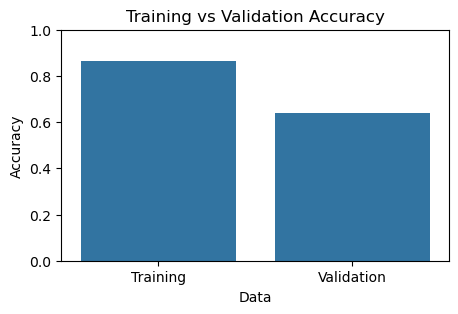

In [38]:
# Plotting the accuracies
plt.figure(figsize=(5, 3))
sns.barplot(x='Data', y='Accuracy', data=accuracies)
plt.ylim(0, 1)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Data')
plt.show()

In [ ]:
Select_Steam.describe().show()

In [ ]:
Select_Steam.count()

In [ ]:
Sample_Steam = Select_Steam.sample(fraction = 0.005, withReplacement=False)
pandas_steam = Sample_Steam.toPandas()

In [ ]:
for n in pandas_steam:
    pandas_steam[n] = pandas_steam[n].astype(int)

In [ ]:
pandas_steam.describe()

In [ ]:
sns.histplot(data=pandas_steam, x='author_playtime_forever', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime Forever Distribution (Logarithmic Scale)')
plt.xlabel('Playtime Forever (minutes)')

In [ ]:
sns.histplot(data=pandas_steam, x='author_playtime_last_two_weeks', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime Last Two Weeks Distribution (Logarithmic Scale)')
plt.xlabel('Playtime Last Two Weeks (minutes)')

In [ ]:
sns.histplot(data=pandas_steam, x='author_playtime_at_review', hue ='voted_up',bins=20, log_scale=True)
plt.title('Playtime at Review Distribution (Logarithmic Scale)')
plt.xlabel('Playtime at Review (minutes)')

4. Plot Data

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_forever', y='author_playtime_last_two_weeks', hue='voted_up')
plt.title('Playtime Forever vs Playtime Last Two Weeks')
plt.xlabel('Playtime Forever (minutes)')
plt.ylabel('Playtime Last Two Weeks (minutes)')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_forever', y='author_playtime_at_review', hue='voted_up')
plt.title('Playtime Forever vs Playtime at Review')
plt.xlabel('Playtime Forever (minutes)')
plt.ylabel('Playtime at Review (minutes)')
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=pandas_steam, x='author_playtime_last_two_weeks', y='author_playtime_at_review', hue='voted_up')
plt.title('Playtime Forever vs Playtime Last Two Weeks')
plt.xlabel('Playtime Last Two Weeks (minutes)')
plt.ylabel('Playtime at Review (minutes)')
plt.show()